### Loading Files

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet


In [2]:
def change_size(df):
    preprocessed = {}
    for i in range(df.shape[0]):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(64,64))
        image = image.reshape(-1)
        preprocessed[df.index[i]] = image
        
    preprocessed = pd.DataFrame(preprocessed).T
    return preprocessed

### Model:

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Concatenate, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, MaxPool2D, Dropout, BatchNormalization, Input, LeakyReLU

resnet = tensorflow.keras.applications.resnet_v2.ResNet101V2(weights='imagenet', include_top = False)

inputs = Input(shape = (64, 64, 1))
input_conv = Conv2D(3, (3,3), padding="same")(inputs)
resnet = resnet(input_conv)

#Classifier part
final_average_pool = GlobalAveragePooling2D()(resnet)
final_dropout = Dropout(rate=0.40)(final_average_pool)
resnet = Dense(512, activation='relu')(resnet)
resnet = Dropout(0.4)(resnet)

root = Dense(168, activation='softmax', name='activation_1_root')(final_dropout) 
vowel = Dense(11, activation='softmax', name='activation_2_vowel')(final_dropout) 
consonant = Dense(7, activation='softmax', name='final_activation_consonant')(final_dropout)


resnet = Model(inputs=inputs, outputs=[root, vowel, consonant])

In [6]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    30          input_4[0][0]                    
__________________________________________________________________________________________________
resnet101v2 (Model)             multiple             42626560    conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet101v2[1][0]                
______________________________________________________________________________________________

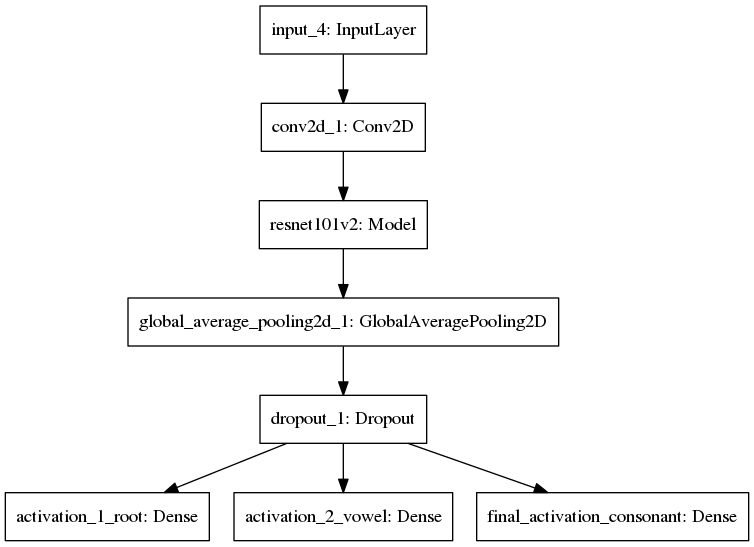

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(resnet)

In [9]:
from tensorflow.keras.optimizers import Adam

resnet.compile(
        optimizer = Adam(lr= 1E-3), 
        loss = "categorical_crossentropy", 
        metrics = ['accuracy']
        )

In [10]:
class DataGenerator(tensorflow.keras.preprocessing.image.ImageDataGenerator):
    
    def flow(self,x, y=None, batch_size=32, shuffle=True): 
        labels = None 
        keys = {} 
        ordered = []
        
        for key, value in y.items():
            labels = value if (labels is None) else (np.concatenate((labels, value), axis=1))
            keys[key] = value.shape[1] 
            ordered.append(key)

        for output_x, output_y in super().flow(x, labels, batch_size=32):
            label_dict = {}
            pos = 0
            
            for label in ordered:
                target_length = keys[label]
                label_dict[label] = output_y[:, pos: pos + target_length] 
                pos += target_length

            yield output_x, label_dict

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping 

reduce_learning_rate = ReduceLROnPlateau(monitor='final_activation_consonant_loss', patience=2, verbose=1)
checkpoint = ModelCheckpoint('best_model_transferlearning.h5', monitor ='val_loss', save_best_only = True, save_weights_only=True)

callbacks = [reduce_learning_rate, checkpoint]

### Training:

In [12]:
import gc
import tqdm
from sklearn.model_selection import train_test_split

In [13]:
train_df = pd.read_csv('../input/bengaliai-cv19/train.csv')

In [14]:
import cv2

In [17]:
histories = []
for i in range(4):
    print('Loading file:', i)
    df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df, on='image_id')

    grapheme = pd.get_dummies(df['grapheme_root']).values
    vowel = pd.get_dummies(df['vowel_diacritic']).values  
    consonant = pd.get_dummies(df['consonant_diacritic']).values

    df.drop(['image_id','grapheme_root','vowel_diacritic','consonant_diacritic','grapheme'], axis=1,inplace=True)
    df = change_size(df).astype('float32')

    df = df.values.reshape(-1, 64, 64, 1)
    df, test_x, train_graph_y, test_graph_y, train_vowel_y, test_vowel_y, train_cons_y, test_cons_y = train_test_split(df, grapheme,vowel,consonant, test_size=0.10)

    del grapheme
    del vowel
    del consonant
    gc.collect()

    gen = DataGenerator(rotation_range= 15, 
                        zoom_range = 0.20,
                        width_shift_range=0.20,
                        height_shift_range=0.20
                       )


    gen.fit(df)
    print('Training:')
    history = resnet.fit_generator(gen.flow(df, {'activation_1_root': train_graph_y, 'activation_2_vowel': train_vowel_y, 'final_activation_consonant': train_cons_y}, batch_size= 32),
                                      epochs = 10,
                                      validation_data = (test_x, [test_graph_y, test_vowel_y, test_cons_y]),
                                      steps_per_epoch= df.shape[0] // 32,
                                      callbacks= callbacks)
    histories.append(history)
    del history
    del df
    del test_vowel_y
    del train_cons_y
    del test_cons_y
    del gen
    del test_x
    del train_graph_y
    del test_graph_y
    del train_vowel_y
    gc.collect()

Loading file: 0
Training:
Train for 1412 steps, validate on 5021 samples
Epoch 1/10
1412/1412 [==============================] - 136s 96ms/step - loss: 4.8389 - activation_1_root_loss: 3.5927 - activation_2_vowel_loss: 0.6648 - final_activation_consonant_loss: 0.5814 - activation_1_root_accuracy: 0.1235 - activation_2_vowel_accuracy: 0.7774 - final_activation_consonant_accuracy: 0.7976 - val_loss: 4.0733 - val_activation_1_root_loss: 3.0937 - val_activation_2_vowel_loss: 0.5614 - val_final_activation_consonant_loss: 0.4180 - val_activation_1_root_accuracy: 0.2087 - val_activation_2_vowel_accuracy: 0.8058 - val_final_activation_consonant_accuracy: 0.8650
Epoch 2/10
1412/1412 [==============================] - 134s 95ms/step - loss: 3.5006 - activation_1_root_loss: 2.5416 - activation_2_vowel_loss: 0.5196 - final_activation_consonant_loss: 0.4394 - activation_1_root_accuracy: 0.3052 - activation_2_vowel_accuracy: 0.8247 - final_activation_consonant_accuracy: 0.8526 - val_loss: 3.2204 - v

Epoch 5/10
1412/1412 [==============================] - 131s 93ms/step - loss: 1.0141 - activation_1_root_loss: 0.6300 - activation_2_vowel_loss: 0.1954 - final_activation_consonant_loss: 0.1887 - activation_1_root_accuracy: 0.8183 - activation_2_vowel_accuracy: 0.9395 - final_activation_consonant_accuracy: 0.9387 - val_loss: 1.0836 - val_activation_1_root_loss: 0.7488 - val_activation_2_vowel_loss: 0.2013 - val_final_activation_consonant_loss: 0.1334 - val_activation_1_root_accuracy: 0.7873 - val_activation_2_vowel_accuracy: 0.9399 - val_final_activation_consonant_accuracy: 0.9588
Epoch 6/10
1412/1412 [==============================] - 133s 94ms/step - loss: 0.9693 - activation_1_root_loss: 0.5933 - activation_2_vowel_loss: 0.1889 - final_activation_consonant_loss: 0.1872 - activation_1_root_accuracy: 0.8255 - activation_2_vowel_accuracy: 0.9428 - final_activation_consonant_accuracy: 0.9383 - val_loss: 0.7523 - val_activation_1_root_loss: 0.5155 - val_activation_2_vowel_loss: 0.1230 -

Epoch 9/10
1412/1412 [==============================] - 134s 95ms/step - loss: 0.6882 - activation_1_root_loss: 0.4111 - activation_2_vowel_loss: 0.1389 - final_activation_consonant_loss: 0.1382 - activation_1_root_accuracy: 0.8783 - activation_2_vowel_accuracy: 0.9552 - final_activation_consonant_accuracy: 0.9532 - val_loss: 0.6126 - val_activation_1_root_loss: 0.4048 - val_activation_2_vowel_loss: 0.1194 - val_final_activation_consonant_loss: 0.0882 - val_activation_1_root_accuracy: 0.8843 - val_activation_2_vowel_accuracy: 0.9675 - val_final_activation_consonant_accuracy: 0.9739
Epoch 10/10
1412/1412 [==============================] - 132s 94ms/step - loss: 0.6735 - activation_1_root_loss: 0.4072 - activation_2_vowel_loss: 0.1321 - final_activation_consonant_loss: 0.1342 - activation_1_root_accuracy: 0.8777 - activation_2_vowel_accuracy: 0.9572 - final_activation_consonant_accuracy: 0.9546 - val_loss: 0.6673 - val_activation_1_root_loss: 0.4629 - val_activation_2_vowel_loss: 0.1081 

In [18]:
import matplotlib.pyplot as plt

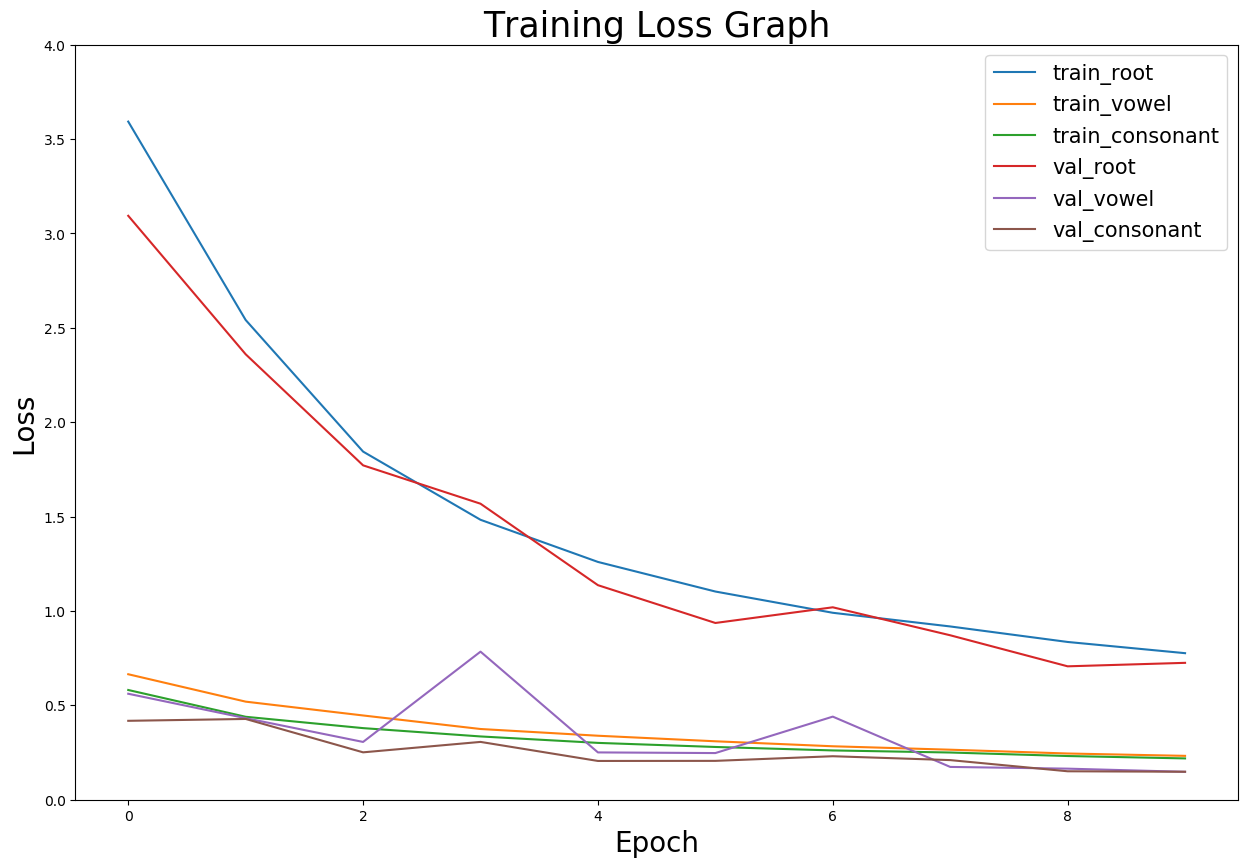

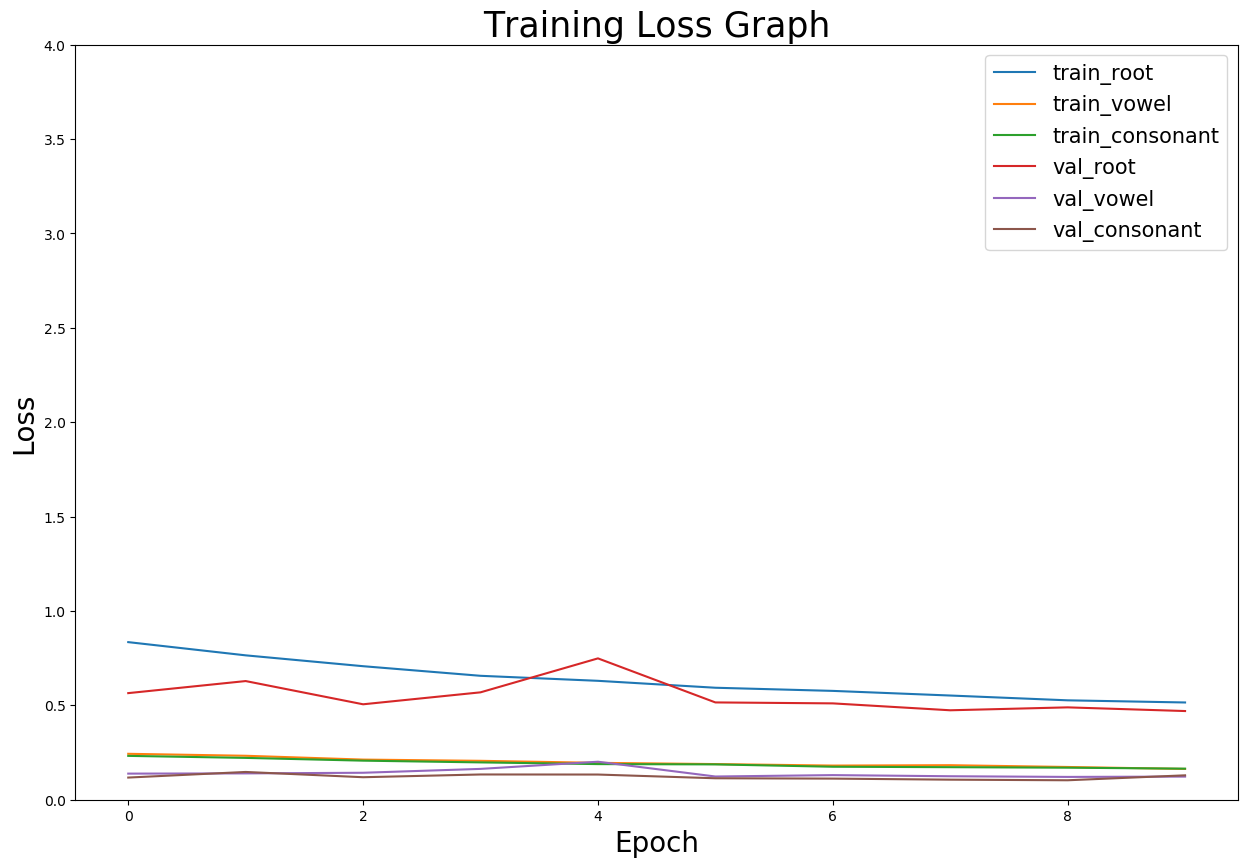

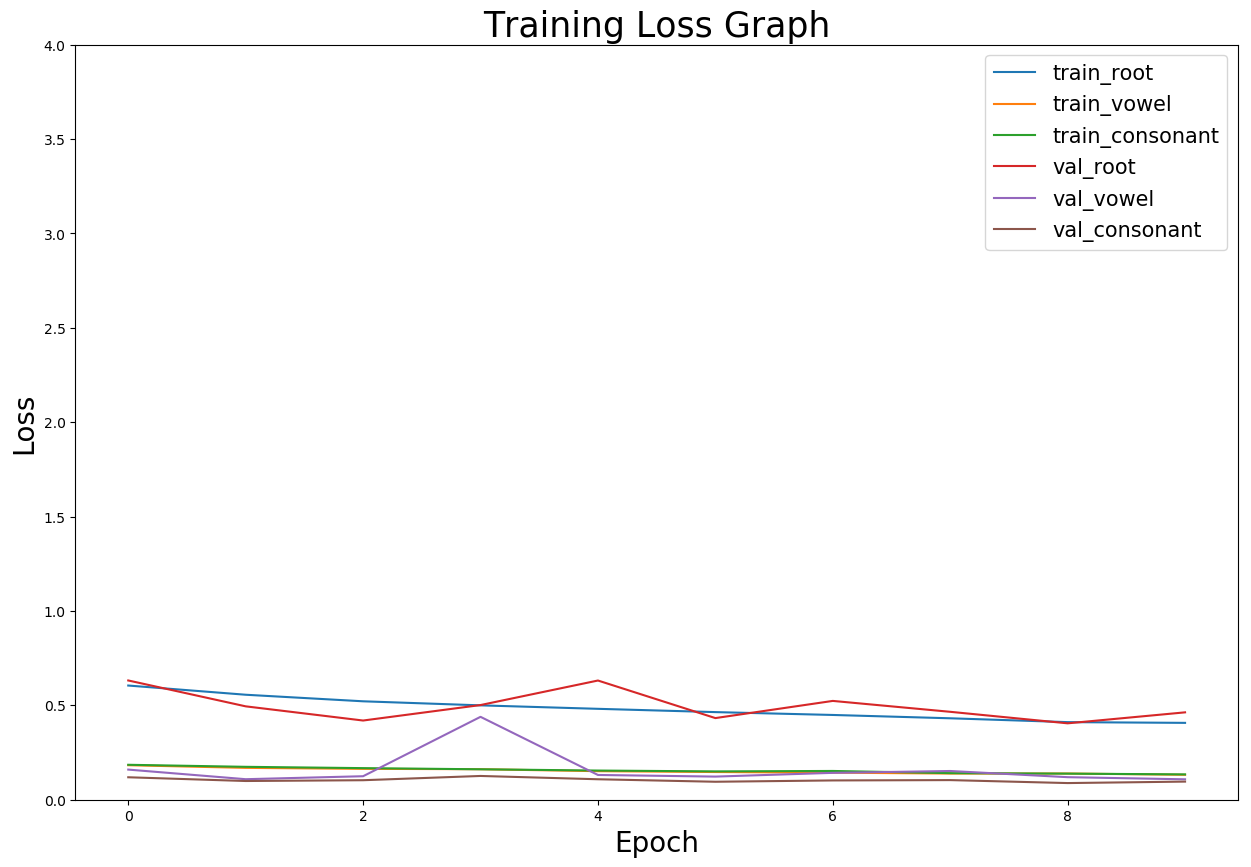

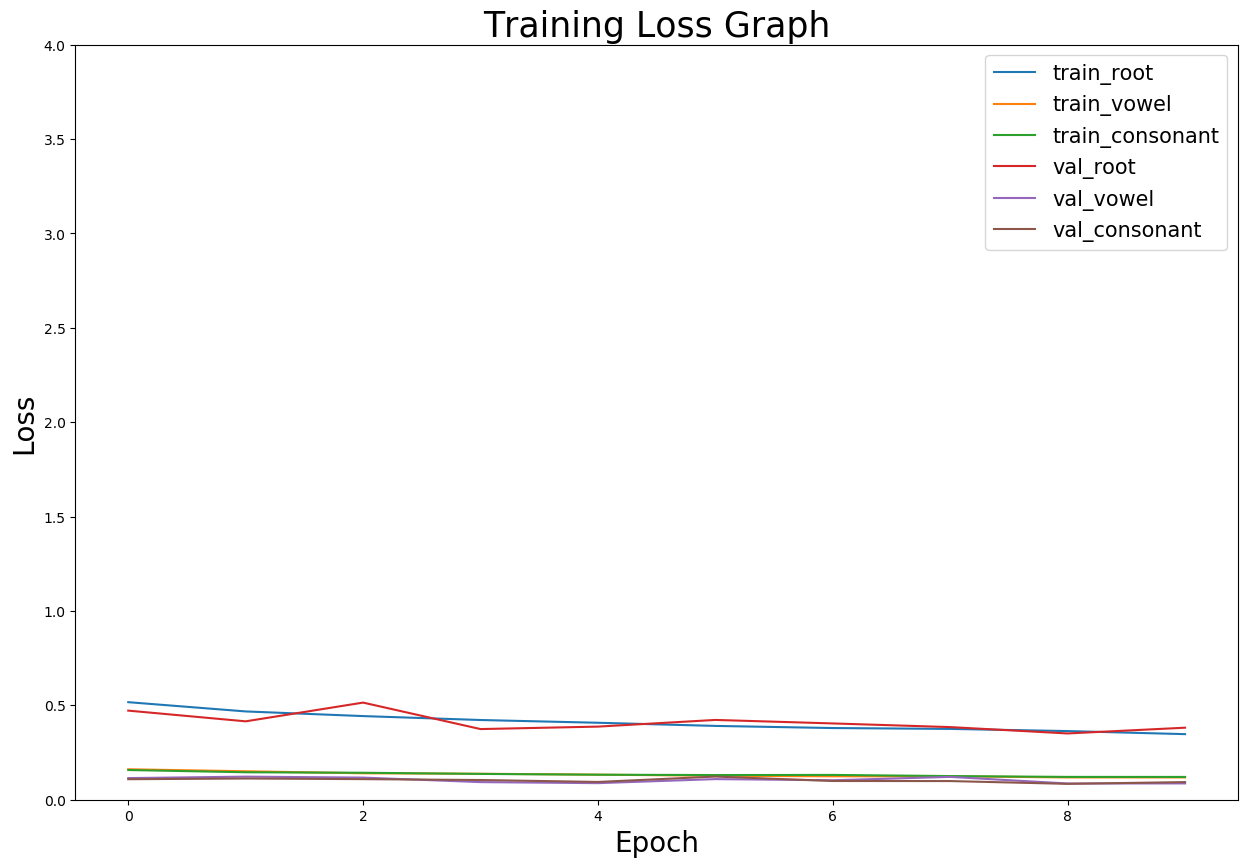

In [20]:
%matplotlib inline
for history in histories:
    plt.figure(figsize=(15, 10), dpi=100)

    plt.title('Training Loss Graph', fontsize=25)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.ylim(0, 4)
    
    plt.plot(np.arange(0.0, 10), history.history['activation_1_root_loss'], label='train_root')
    plt.plot(np.arange(0.0, 10), history.history['activation_2_vowel_loss'], label='train_vowel')
    plt.plot(np.arange(0.0, 10), history.history['final_activation_consonant_loss'], label='train_consonant')

    plt.plot(np.arange(0.0, 10), history.history['val_activation_1_root_loss'], label='val_root')
    plt.plot(np.arange(0.0, 10), history.history['val_activation_2_vowel_loss'], label='val_vowel')
    plt.plot(np.arange(0.0, 10), history.history['val_final_activation_consonant_loss'], label='val_consonant')

    plt.legend(loc='upper right', fontsize=15)
    plt.show()

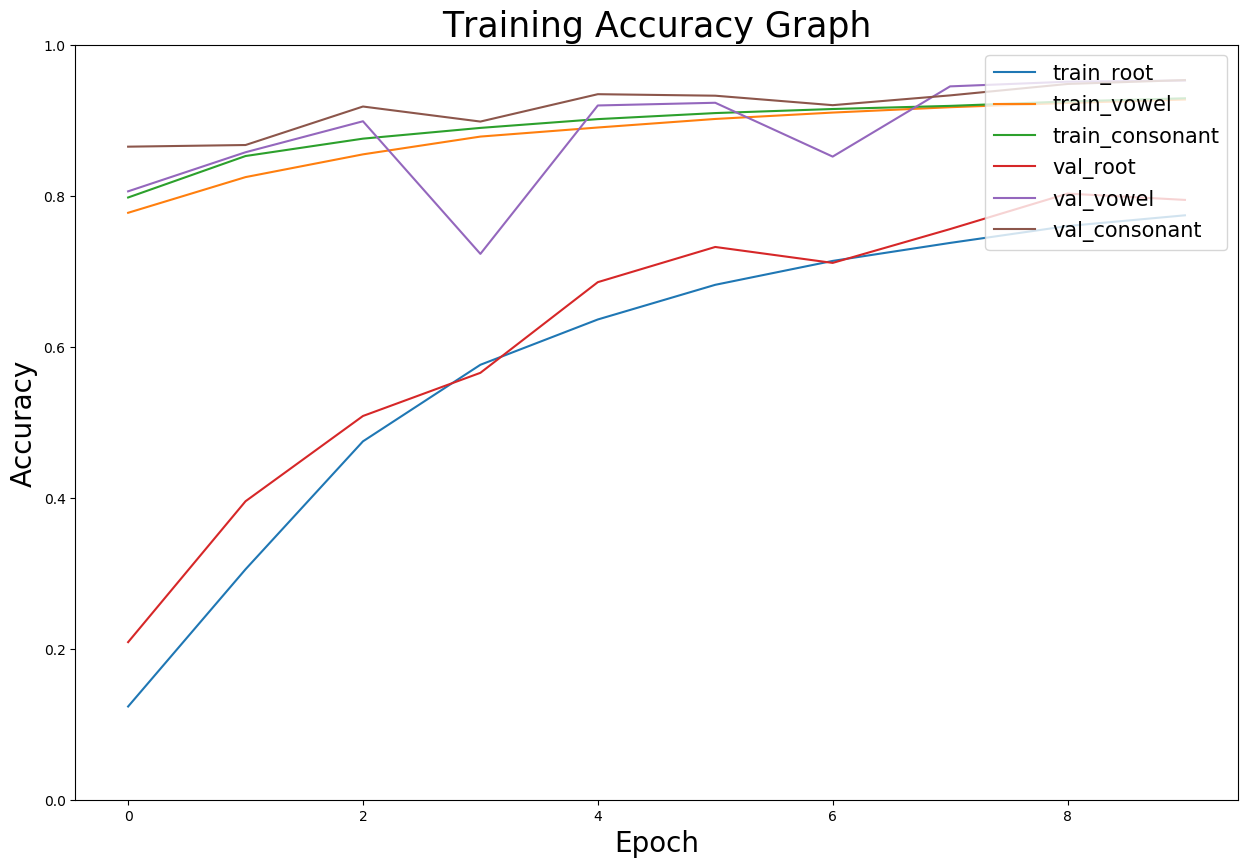

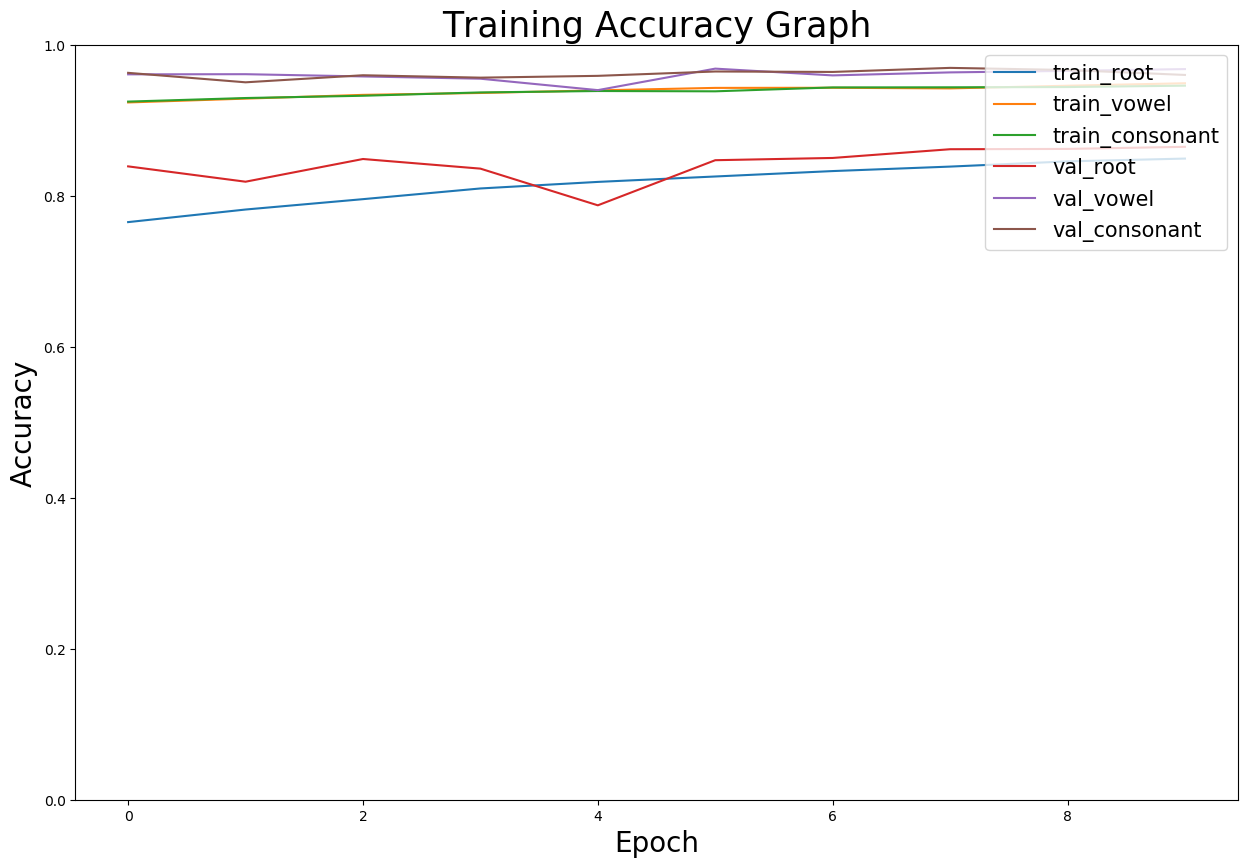

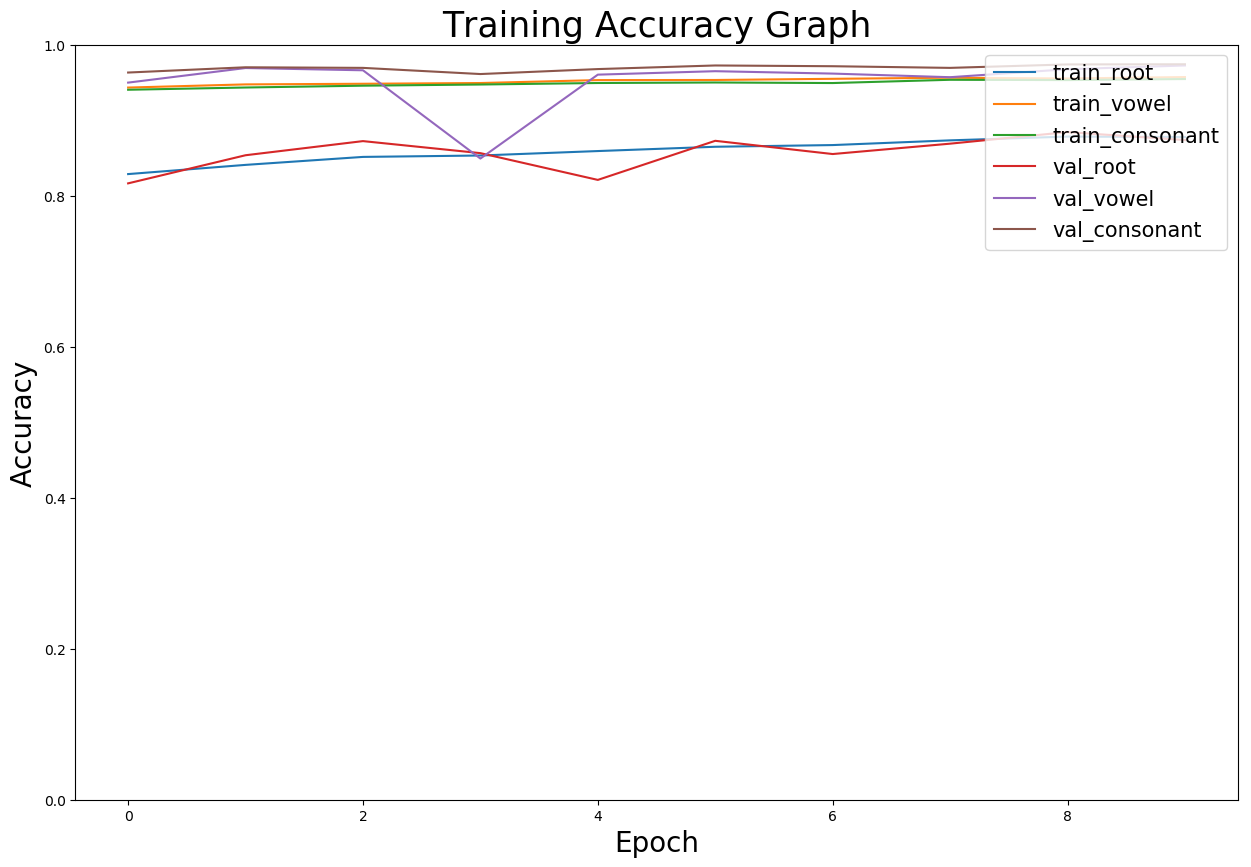

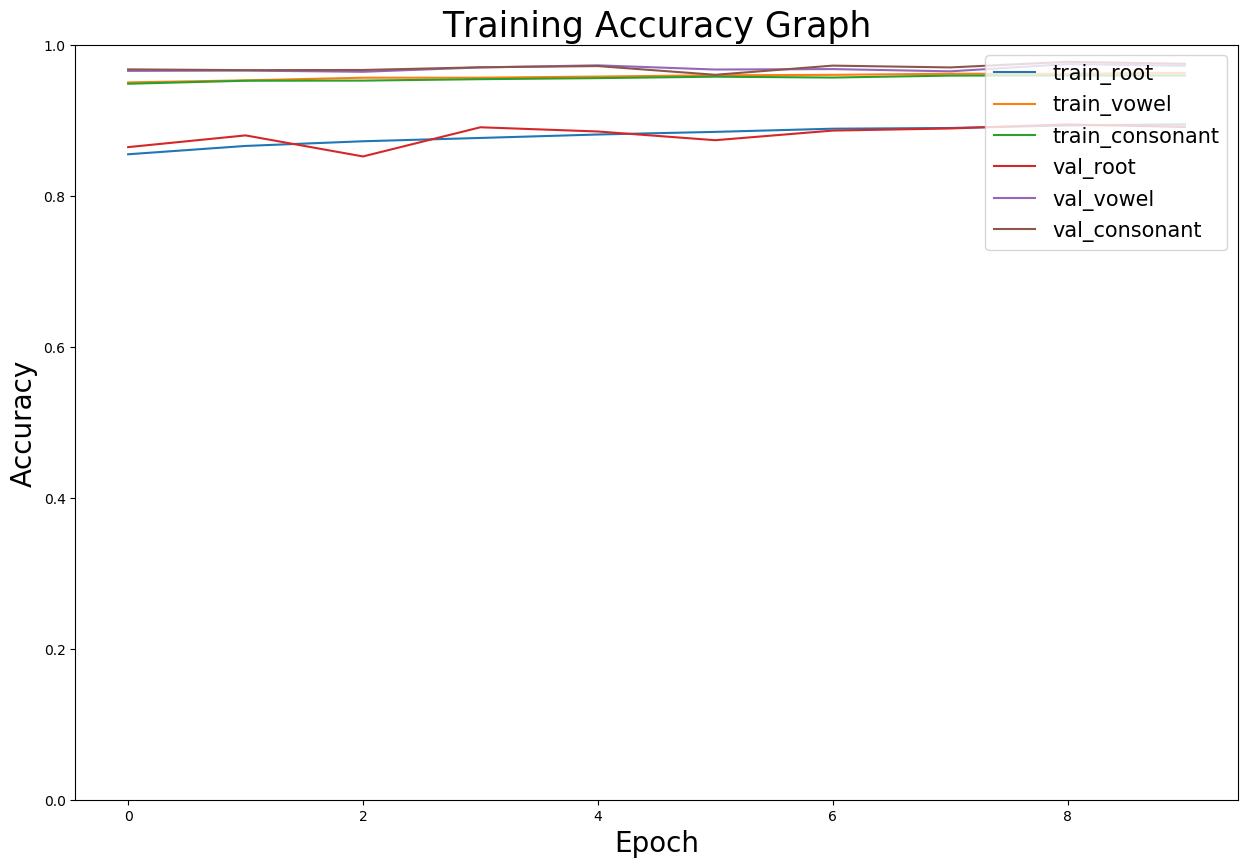

In [21]:
for history in histories:
    plt.figure(figsize=(15, 10), dpi=100)

    plt.title('Training Accuracy Graph', fontsize=25)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.ylim(0, 1)

    plt.plot(np.arange(0.0, 10), history.history['activation_1_root_accuracy'], label='train_root')
    plt.plot(np.arange(0.0, 10), history.history['activation_2_vowel_accuracy'], label='train_vowel')
    plt.plot(np.arange(0.0, 10), history.history['final_activation_consonant_accuracy'], label='train_consonant')

    plt.plot(np.arange(0.0, 10), history.history['val_activation_1_root_accuracy'], label='val_root')
    plt.plot(np.arange(0.0, 10), history.history['val_activation_2_vowel_accuracy'], label='val_vowel')
    plt.plot(np.arange(0.0, 10), history.history['val_final_activation_consonant_accuracy'], label='val_consonant')

    plt.legend(loc='upper right', fontsize=15)
    plt.show()